## Домашнее задание №1

В этом домашнем задании вы познакомитесь с pytorch сами и сможете попрактиковаться в его применении. 

#### План:

1. Простейшие операции в pytorch
2. Пишем Adam и применяем его к ручной модели
3. Обучаем свою первую нейросеть

In [ ]:
import os
import sys
import math
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import random
import numpy as np
from tqdm.notebook import tqdm
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm.notebook import tqdm

### Простейшие операции на pytorch (2 балла)

**Task**: Cоздайте два случайных тензора (двумерных, не квадратных):

In [ ]:
x = torch.randn(3, 2)
y = torch.randn(2, 3)

**Task**: Умножьте их друг на друга, результат запишите в третий тензор без использования оператора `=`:

In [ ]:
z = torch.empty(1)
torch.matmul(x, y, out=z)

tensor([[-0.5277, -1.1989, -0.0245],
        [-2.7219, -4.2552,  0.1600],
        [-0.0419,  1.0800,  0.1726]])

**Task**: Реализуйте ReLU использую только pytorch, примените его к тензору `x` (запрещено использование модулей torch.nn и его подмодулей, а также функции torch.relu)

In [ ]:
def relu_forward(x):
    
    return torch.where(x>0, x, torch.zeros_like(x))

assert torch.all(F.relu(x) == relu_forward(x))

**Task**: Сделайте тоже самое c ELU (запрещено использование модулей torch.nn и его подмодулей):

In [ ]:
def elu_forward(x):
    
    return torch.where(x>0, x, torch.exp(x)-1)
  

assert torch.all(F.elu(x) == elu_forward(x))

**Task**: LeakyReLU (запрещено использование модулей torch.nn и его подмодулей):

In [ ]:
def lrelu_forward(x, alpha):

    return torch.where(x>0, x, alpha*x)

assert torch.all(F.leaky_relu(x, 0.01) == lrelu_forward(x, 0.01))

**Task**: Теперь перейдем к немного более современным функциям активаций, например Mish, напомним как она выглядит:

$$x * tanh(ln(1+e^x))$$

(запрещено использование модулей torch.nn и его подмодулей)

In [ ]:
def mish(x):
    return x * torch.tanh(torch.log(1 + torch.exp(x)))

In [ ]:
assert torch.allclose(
    mish(torch.tensor([1, 1, 1], dtype=torch.float32)), 
    torch.tensor([0.8651, 0.8651, 0.8651]), 
    atol=1e-4
)

assert torch.allclose(
    mish(torch.tensor([0.6376, 0.4021, 0.6656, 0.3726], dtype=torch.float64)), 
    torch.tensor([0.5014, 0.2908, 0.5280, 0.2663], dtype=torch.float64), 
    atol=1e-4
)

**Task**: Теперь реализуем swish, напомним как она выглядит:

$$x * \sigma(x)$$

(запрещено использование модулей torch.nn и его подмодулей)

In [ ]:
def swish(x):
    return x * torch.sigmoid(x)

In [ ]:
assert torch.allclose(
    swish(torch.tensor([1, 1, 1], dtype=torch.float32)), 
    torch.tensor([0.7311, 0.7311, 0.7311]), 
    atol=1e-4
)

assert torch.allclose(
    swish(torch.tensor([0.6376, 0.4021, 0.6656, 0.3726], dtype=torch.float64)), 
    torch.tensor([0.4171, 0.2409, 0.4396, 0.2206], dtype=torch.float64), 
    atol=1e-4
)

### Пишем Adam и применяем его к линейной регрессии (4 балла)


В данной секции вам нужно сделать две вещи: 

1. Написать свой собственный оптимизатор подобно тому, который мы писали на семинаре
2. Обучить логистическую регрессию побатчево на картинках из датасета 


#### Adam


$$
\begin{eqnarray}
g &=& \frac{1}{m}\nabla_w \sum_i L(f(x_{i};w), y_{i}) \\
m &=& \beta_1 m + (1 - \beta_1) g \\
v &=& \beta_2 v + (1 - \beta_2) diag(gg^{T}) \\
\hat{m} &=& \frac{m}{1 - \beta_1^{t}} \\
\hat{v} &=& \frac{v}{1 - \beta_2^{t}} \\
w &=& w - \frac{\eta}{\sqrt{\hat{v} + \epsilon}} \odot \hat{m}
\end{eqnarray}
$$

In [ ]:
# абстрактный класс, не обращайте внимания
from torch.optim import Optimizer


class InClassOptimizer(Optimizer):
    def step(self):
        """Perform single optimization step."""
        with torch.no_grad(): # выключим градиенты
            for group in self.param_groups:
                self._group_step(group)

    def _group_step(self, group):
        # group ~ dict[str, ...]
        """
        Private helper function to perform
        single optimization step on model parameters.
        """
        raise NotImplementedError()

**Task**: Напишите свою реализацию Adam:

In [ ]:
class Adam(InClassOptimizer):
    def __init__(self, params, lr=0.001, eps=1e-13, beta_1=0.9, beta_2=0.999):
        defaults = dict(lr=lr, eps=eps, beta_1=beta_1, beta_2=beta_2)
        super().__init__(params, defaults)

    def _group_step(self, group):
        # One group contains information about values passed in init
        # and model parameters to update
        lr = group['lr']
        eps = group['eps']
        beta_1 = group['beta_1']
        beta_2 = group['beta_2']

        state = self.state
        if len(state) == 0:
            state['step'] = 0
        state['step'] += 1
        step = state['step']

        for param in filter(lambda x: x.grad is not None, group['params']):
            self._init_adam_buffer(param)
            grad = param.grad
            m, v = self._get_adam_buffer(param)
            m.mul_(beta_1).add_(grad, alpha=1 - beta_1)
            v.mul_(beta_2).add_(grad**2, alpha=1 - beta_2)
            m_hat = m / (1 - beta_1 ** step)
            v_hat = v / (1 - beta_2 ** step)
            weight = 1 / (v_hat + eps)**0.5

            param.add_(m_hat * weight, alpha = -lr)



    def _get_adam_buffer(self, param):
        """
        Get accumulated gradients for Adam.

        Parameters
        ----------
        param : `torch.Tensor`, required
            Model parameter to get accumulated gradeints for Adagrad.

        Returns
        -------
        Accumulated Adam gradients for parameter.
        """
        return self.state[param]['m'], self.state[param]['v']

    def _init_adam_buffer(self, param):
        """
        Initialize accumulated gradeints for adam.

        Parameters
        ----------
        param : `torch.Tensor`, required
            Model parameter to get accumulated gradeints for adam.
        """
        param_state = self.state[param]

        if 'm' not in param_state:
            param_state['m'] = torch.zeros_like(param)

        if 'v' not in param_state:
            param_state['v'] = torch.zeros_like(param)


**Task**: Создайте параметры для обучения линейной регрессии, сделаем Xavier ициализацию, которая выглядит следующим образом: 

$$w \sim U[-\frac{\sqrt{6}}{\sqrt{n_{in} + n_{out}}}, \frac{\sqrt{6}}{\sqrt{n_{in} + n_{out}}}]$$

где: 

* $n_{in}$ -- размер входа (в нейронах) 
* $n_{out}$ -- размер выхода (в нейронах)

Подумайте над выбором $n_{in}$ и $n_{out}$ самостоятельно. 

$n_{in} = 784$

$n_{out}= 10$

In [ ]:
low = (-6 ** 0.5)/(784 + 10)**0.5
high = -low

In [ ]:
weights = torch.distributions.uniform.Uniform(torch.tensor(low), torch.tensor(high)).sample((784, 10))
intercept = torch.distributions.uniform.Uniform(torch.tensor(low), torch.tensor(high)).sample((1, 10))

In [ ]:
weights.requires_grad_()
intercept.requires_grad_()

tensor([[ 0.0466, -0.0239, -0.0012,  0.0824,  0.0201,  0.0849, -0.0062, -0.0205,
         -0.0680,  0.0500]], requires_grad=True)

Загрузим данные и создадим даталоадеры:

In [ ]:
fashion_mnist_train = torchvision.datasets.FashionMNIST(
    './data',
    train=True,
    download=True,
    transform=transforms.Compose([transforms.ToTensor()])
)
train_dataloader = DataLoader(fashion_mnist_train, batch_size=128, shuffle=True, num_workers=2)

fashion_mnist_eval = torchvision.datasets.FashionMNIST(
    './data',
    train=False,
    download=True,
    transform=transforms.Compose([transforms.ToTensor()])
)
test_dataloader = DataLoader(fashion_mnist_eval, batch_size=128, shuffle=False, num_workers=2)

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Напишите функцию для тренировки логистической регрессии, она должна: 
    * Делать предсказания 
    * Считать лосс 
    * Подсчитывать градиенты
    * Делать шаг оптимизации
    * Обнулять посчитанные градиенты
    * Считать метрики 
    * Возвращать полученные метрики
    
После этого предусмотрите возможность визуализировать метрики, чтобы нарисовать картинки, а именно от вас требуется визуализировать: 

    * Зависимость лосса от количества итераций
    * Зависимость доли правильных ответов от количества итераций

In [ ]:
class LinearRegression(torch.nn.Module):

    def __init__(self, weights, bias):
        super().__init__()
        self.weights = weights
        self.bias = bias

    def forward(self, x):
        x = nn.Flatten()(x)
        pred = x @ self.weights + self.bias
        return pred

    def parameters(self):
        return (self.weights, self.bias)


In [ ]:
linreg = LinearRegression(weights, intercept)

In [ ]:
def train_model_cpu(model, train_dataloader, val_dataloader, optimizer, nn_name:str, optim_name:str): #gpu вечно выдавал illegal acces
    loss_func = nn.CrossEntropyLoss()
    train_loss = []
    train_accuracy = []
    train_epoch_len = []
    val_loss_plot = []
    val_accuracy_plot = []
    for epoch in range(1, 51):

        model.train()
        batch_num = 0

        for data, answers in train_dataloader:

          

            optimizer.zero_grad()
            pred = model(data)
            loss = loss_func(pred, answers)
            loss.backward()
            optimizer.step()

            train_loss.append(loss.item()/len(pred))
            train_accuracy.append((torch.argmax(pred, dim=1) == answers).sum().item()/len(pred))
            batch_num += 1
          
        train_epoch_len.append(batch_num)

        model.eval()
        val_loss = []
        val_accuracy = []

        with torch.no_grad():
            
            for data, answers in train_dataloader:

      

                pred = model(data)
                loss = loss_func(pred, answers)

                val_loss.append(loss.item()/len(pred))
                val_accuracy.append((torch.argmax(pred, dim=1) == answers).sum().item()/len(pred))
        val_loss_plot.append(sum(val_loss)/len(val_loss))
        val_accuracy_plot.append(sum(val_accuracy)/ len(val_accuracy))


        clear_output()
        plt.figure()
        plt.plot(np.arange(1, sum(train_epoch_len)+1), train_loss, label='train', color='blue', zorder=1)
        plt.scatter(np.array(train_epoch_len) * np.arange(1, epoch+1), val_loss_plot, color='red', label='val', zorder=2)
        plt.xlabel('Batch number')
        plt.ylabel('Loss')
        plt.title(f'Loss, Model: {nn_name}, Optimizer: {optim_name}')
        plt.legend()
        plt.show()
        plt.figure()
        plt.plot(np.arange(1, sum(train_epoch_len)+1), train_accuracy, label='train', color='blue', zorder=1)
        plt.scatter(np.array(train_epoch_len) * np.arange(1, epoch+1), val_accuracy_plot, color='red', label='val', zorder=2)
        plt.xlabel('Batch number')
        plt.ylabel('Loss')
        plt.title(f'Accuracy, Model: {nn_name}, Optimizer: {optim_name}')
        plt.legend()
        plt.show()
        print(f'epoch: {epoch}')
    
    print(f'{nn_name} with {optim_name} training done')
    print(f'Vall loss: {val_loss_plot[-1]} \nVall accuracy: {val_accuracy_plot[-1]}')

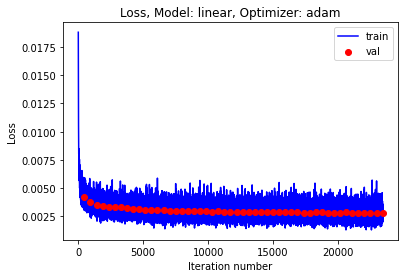

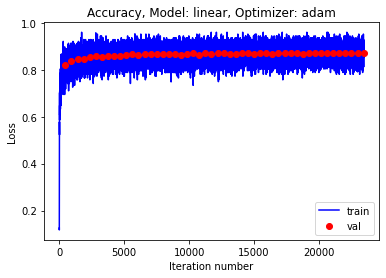

epoch: 50
linear with adam training done
Vall loss: 0.0028319104621617104 
Vall accuracy: 0.8717572850035537


In [ ]:
train_model_cpu(linreg, train_dataloader, test_dataloader, Adam(linreg.parameters()), 'Linreg', 'Adam')

#### Вопросы к секции: 

* Своими словами и без математики объясните благодаря чему Adam дает несмещенную оценку на квадрат градиента
* Когда модель начала переобучаться? Как вы это поняли? Сделайте визуализацию и докажите свою точку зрения.

Ответы

1. Adam на каждом шаге накапливает квадрат градиента батча с некоторым весом. Перед шагом все накопленные квадраты усредняются, что позволяет получить несмещенную оценку градиента функции по всем объектам, а не только по объектам батча. Если градиент функции меняется в зависимости от итераций(а так и происходит во время спуска), то это не проблема, потому что старые квадраты градиента оказываются в оценке с меньшим весом и получается оценка актуального на данном шаге градиента.

2. Логистическая регрессия не начала переобучаться. На графике видно, что модель максимально реализовала свои разделяющие способности и достигла максимального качества на обучающей и на тестовой выборке на первых 5 эпохах. На последующих логистическая регрессия не переобучилась, так как это слишком простая модель для разделения такой выборки и даже с бесконечным количеством эпох она не сможет выдавать лучшее качество ни на трейне ни на валидации

### Моя первая нейросеть (4 балла)

В данной секции вам нужно сделать следующие вещи: 

* Реализовать три разных архитектуры нейросетей. Эти архитектуры должны принципиально отличаться друг от друга. Разрешается одной из архитекур брать полностью полносвязную модель. Остальные две должны быть сверточными и сильно отличаться друг от друга. К примеру, одна из таких архитектур может быть VGG подобная сеть, а другая ResNet подобная архитектура. 

* Написать цикл для обучения которым можно обучать все три модели без изменений кода

* Попробовать каждую модель с двумя оптимизаторами: RMSprop и SGD with momentum

* Визуализировать результаты перфоманса каждой модели (две метрики минимум для каждого сетапа, например, лосс и долю правильных ответов). В данном пункте мы ждем от вас визуализацию зависимости метрики от номера итерации обучения.

* Сделать выводы какие были модели были лучше и как вы думаете почему?

In [ ]:
def train_model(model, train_dataloader, val_dataloader, optimizer, nn_name:str, optim_name:str):
    loss_func = nn.CrossEntropyLoss()
    train_loss = []
    train_accuracy = []
    train_epoch_len = []
    val_loss_plot = []
    val_accuracy_plot = []
    for epoch in range(1, 51):

        model.train()
        batch_num = 0

        for data, answers in train_dataloader:

            data = data.to('cuda:0')
            answers = answers.to('cuda:0')

            optimizer.zero_grad()
            pred = model(data)
            loss = loss_func(pred, answers)
            loss.backward()
            optimizer.step()

            train_loss.append(loss.item()/len(pred))
            train_accuracy.append((torch.argmax(pred, dim=1) == answers).sum().item()/len(pred))
            batch_num += 1
          
        train_epoch_len.append(batch_num)

        model.eval()
        val_loss = []
        val_accuracy = []

        with torch.no_grad():
            
            for data, answers in train_dataloader:

                data = data.to('cuda:0')
                answers = answers.to('cuda:0')

                pred = model(data)
                loss = loss_func(pred, answers)

                val_loss.append(loss.item()/len(pred))
                val_accuracy.append((torch.argmax(pred, dim=1) == answers).sum().item()/len(pred))
        val_loss_plot.append(sum(val_loss)/len(val_loss))
        val_accuracy_plot.append(sum(val_accuracy)/ len(val_accuracy))


        clear_output()
        plt.figure()
        plt.plot(np.arange(1, sum(train_epoch_len)+1), train_loss, label='train', color='blue', zorder=1)
        plt.scatter(np.array(train_epoch_len) * np.arange(1, epoch+1), val_loss_plot, color='red', label='val', zorder=2)
        plt.xlabel('Batch number')
        plt.ylabel('Loss')
        plt.title(f'Loss, Model: {nn_name}, Optimizer: {optim_name}')
        plt.legend()
        plt.show()
        plt.figure()
        plt.plot(np.arange(1, sum(train_epoch_len)+1), train_accuracy, label='train', color='blue', zorder=1)
        plt.scatter(np.array(train_epoch_len) * np.arange(1, epoch+1), val_accuracy_plot, color='red', label='val', zorder=2)
        plt.xlabel('Batch number')
        plt.ylabel('Loss')
        plt.title(f'Accuracy, Model: {nn_name}, Optimizer: {optim_name}')
        plt.legend()
        plt.show()
        print(f'epoch: {epoch}')
    
    print(f'{nn_name} with {optim_name} training done')
    print(f'Vall loss: {val_loss_plot[-1]} \nVall accuracy: {val_accuracy_plot[-1]}')

In [ ]:
class FirstModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=5, padding=2)
        self.norm = nn.BatchNorm2d(num_features=64)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, padding=1)


        self.convblock_128_incr = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=1),
            nn.BatchNorm2d(128)
        )

        self.convblock_128 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=1),
            nn.BatchNorm2d(128)
        )

        self.convblock_256_incr = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=1, stride=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=1, stride=1),
            nn.BatchNorm2d(256)
        )

        self.convblock_256 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=1, stride=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=1, stride=1),
            nn.BatchNorm2d(256)
        )

        
        self.convblock_128_short = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=1)
        self.convblock_256_short = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=1, stride=2)
        self.avg_pool = nn.AdaptiveAvgPool3d((1,1,10))
        self.softmax = nn.Softmax()
        self.flatten = nn.Flatten()


    def forward(self, x):

        x1 = self.pool(self.relu(self.norm(self.conv(x))))
        x2 = self.relu(self.convblock_128_incr(x1) + self.convblock_128_short(x1))
        x3 = self.relu(self.convblock_128(x2) + x2)
        x4 = self.relu(self.convblock_128(x3) + x3)
        x5 = self.relu(self.convblock_128(x4) + x4)
        x6 = self.relu(self.convblock_256_incr(x5) + self.convblock_256_short(x5))
        x7 = self.relu(self.convblock_256(x6) + x6)
        x8 = self.relu(self.convblock_256(x7) + x7)
        x9 = self.relu(self.convblock_256(x8) + x8)
        x10 = self.softmax(self.flatten(self.avg_pool(x9)))
        return x10

In [ ]:
second_model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1),
    nn.BatchNorm2d(16),
    nn.ReLU(),

    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(), 

    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),

    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(),

    nn.Flatten(),

    nn.Linear(in_features=1152, out_features=1152),
    nn.Dropout(0.5),
    nn.ReLU(),
    nn.Linear(in_features=1152, out_features=1152),
    nn.Dropout(0.5),
    nn.ReLU(),
    nn.Linear(in_features=1152, out_features=10)
)

In [ ]:
class ThirdModel(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.layers = torch.nn.ModuleDict({
            'relu' : nn.ReLU(),
            'start': nn.Sequential(nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1),
                                   nn.BatchNorm2d(16)),
            'second': nn.Sequential(nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
                                    nn.BatchNorm2d(32)),
            'block_64': nn.Sequential(nn.Conv2d(in_channels=32, out_channels=64, kernel_size=1),
                                      nn.BatchNorm2d(64),
                                      nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1, groups=64),
                                      nn.BatchNorm2d(64),
                                      nn.ReLU(),
                                      nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1),
                                      nn.BatchNorm2d(64),
                                      nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1, groups=64),
                                      nn.BatchNorm2d(64),
                                      nn.MaxPool2d(kernel_size=2, stride=2)),
            'block_128': nn.Sequential(nn.ReLU(),
                                      nn.Conv2d(in_channels=64, out_channels=128, kernel_size=1),
                                      nn.BatchNorm2d(128),
                                      nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1, groups=128),
                                      nn.BatchNorm2d(128),
                                      nn.ReLU(),
                                      nn.Conv2d(in_channels=128, out_channels=128, kernel_size=1),
                                      nn.BatchNorm2d(128),
                                      nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1, groups=128),
                                      nn.BatchNorm2d(128)),
            'block': nn.Sequential(nn.ReLU(),
                                      nn.Conv2d(in_channels=128, out_channels=128, kernel_size=1),
                                      nn.BatchNorm2d(128),
                                      nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1, groups=128),
                                      nn.BatchNorm2d(128),
                                      nn.ReLU(),
                                      nn.Conv2d(in_channels=128, out_channels=128, kernel_size=1),
                                      nn.BatchNorm2d(128),
                                      nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1, groups=128),
                                      nn.BatchNorm2d(128),
                                      nn.ReLU(),
                                      nn.Conv2d(in_channels=128, out_channels=128, kernel_size=1),
                                      nn.BatchNorm2d(128),
                                      nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1, groups=128),
                                      nn.BatchNorm2d(128)),
            '64': nn.Sequential(nn.Conv2d(in_channels=32, out_channels=64, kernel_size=1, stride=2),
                                nn.BatchNorm2d(64)),
            '128': nn.Sequential(nn.Conv2d(in_channels=64, out_channels=128, kernel_size=1),
                                 nn.BatchNorm2d(128)),
            'pool': nn.Sequential(nn.AvgPool2d(kernel_size=13),
                                  nn.Flatten()),
            'dropout': nn.Dropout(0.5),
            'logreg': nn.Sequential(nn.Linear(in_features=128, out_features=10),
                                    nn.Softmax())
        })  


    def forward(self, x):

        x = self.layers['start'](x)
        x = self.layers['relu'](x)
        x = self.layers['second'](x)
        x = self.layers['relu'](x)
        x = self.layers['block_64'](x) + self.layers['64'](x)
        x = self.layers['block_128'](x) + self.layers['128'](x)
        x = self.layers['block'](x) + x
        x = self.layers['block'](x) + x
        x = self.layers['pool'](x)
        x = self.layers['dropout'](x)
        x = self.layers['logreg'](x)
      
        
        return x
                    

In [ ]:
first_model = FirstModel()
first_model.to(device='cuda:0')
second_model.to(device='cuda:0')
third_model = ThirdModel()
third_model.to(device='cuda:0')

ThirdModel(
  (layers): ModuleDict(
    (128): Sequential(
      (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (64): Sequential(
      (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(2, 2))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (block): Sequential(
      (0): ReLU()
      (1): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
      (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=128)
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
      (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): Conv2d(128, 128, kernel_size=(3, 3),

### Обучение ResNet

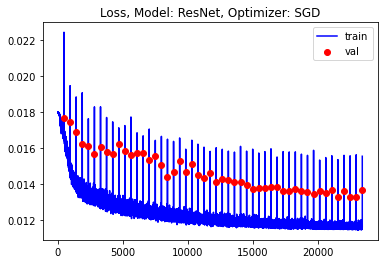

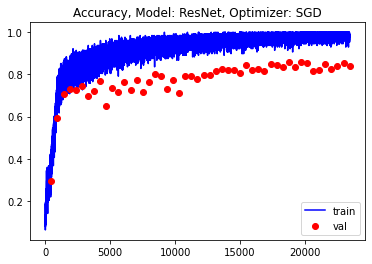

epoch: 50
ResNet with SGD training done
Vall loss: 0.01365333448039062 
Vall accuracy: 0.8403906805259418


In [ ]:
train_model(first_model, train_dataloader, test_dataloader, optim.SGD(first_model.parameters(), lr=0.001, momentum=0.9), 'ResNet', 'SGD')

In [ ]:
first_model = FirstModel()
first_model.to('cuda:0')

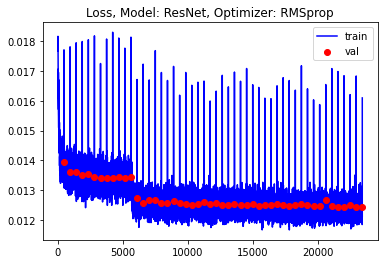

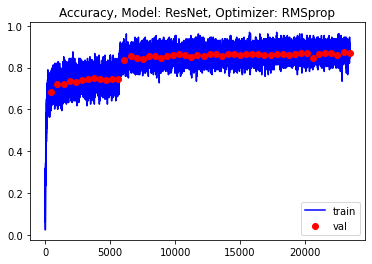

epoch: 50
ResNet with RMSprop training done
Vall loss: 0.012447041740036002 
Vall accuracy: 0.869247512437811


In [ ]:
train_model(first_model, train_dataloader, test_dataloader, optim.RMSprop(first_model.parameters(), lr=0.001, momentum=0.9, eps=1e-6), 
            'ResNet', 'RMSprop')

#### Комментарии

Реализация ResNet в итоге получилась довольно глубокая, с оптимизатором SGD сеть переобучилась. Точность на большей части тестовой выборки на последних эпохах получилась близкой к одному, однако на валидации ошибок была гораздо больше. Для ограничения переобучения можно было использовать дропауты, но в оригинальной работе их не было и хотелось попробовать обучить максимально близко к оригиналу(но с большим количеством слоев совсем не училась). Кажется, при разработке ResNet использовался датасет с большим количеством картинок и большим размером картинки и поэтому глубина сети на оригинальном датасете не вызывала переобучения. С оптимизатором RMSProp переобучения не случилось, кажется, причиной этому послужило маленькое количество эпох и с его увеличением модель бы могла переобучиться 


### Обучение VGG

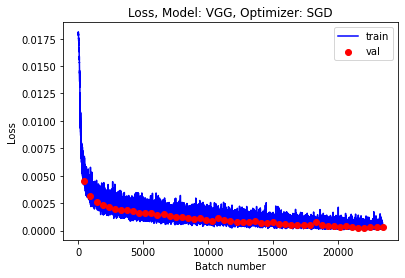

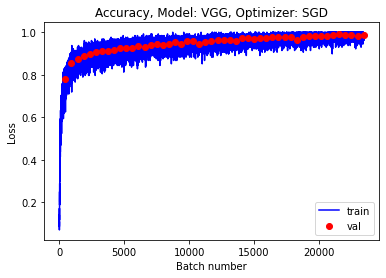

epoch: 50
VGG with SGD training done
Vall loss: 0.0003187779362806829 
Vall accuracy: 0.9856687544420752


In [ ]:
train_model(second_model, train_dataloader, test_dataloader, optim.SGD(second_model.parameters(), lr=0.001, momentum=0.9), 'VGG', 'SGD')

In [ ]:
second_model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1),
    nn.BatchNorm2d(16),
    nn.ReLU(),

    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(), 

    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),

    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(),

    nn.Flatten(),

    nn.Linear(in_features=1152, out_features=1152),
    nn.Dropout(0.5),
    nn.ReLU(),
    nn.Linear(in_features=1152, out_features=1152),
    nn.Dropout(0.5),
    nn.ReLU(),
    nn.Linear(in_features=1152, out_features=10)
)

In [ ]:
second_model.to('cuda:0')

Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU()
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (12): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (14): ReLU()
  (15): Flatten()
  (16): Linear(in_feat

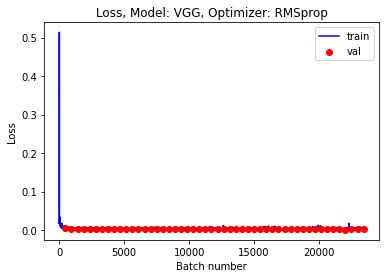

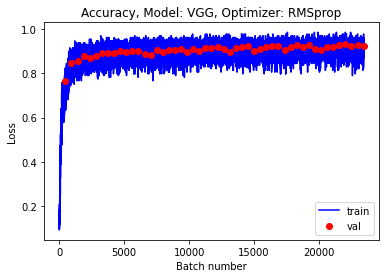

epoch: 50
VGG with RMSprop training done
Vall loss: 0.001790248134915466 
Vall accuracy: 0.9220748933901919


In [ ]:
train_model(second_model, train_dataloader, test_dataloader,optim.RMSprop(second_model.parameters(), lr=0.001, momentum=0.9, eps=1e-6), 
            'VGG', 'RMSprop')

#### Комментарии

С учетом опыта использования ResNet, VGG была сделана относительно неглубокой - всего 3 блока. Оба оптимизатора показали высокую точность, однако точность SGD дошла до 1 на по многим батчам тренировочной выборки, а его точность на валидации была значительно больше точности RMSProp

### Обучение Xception


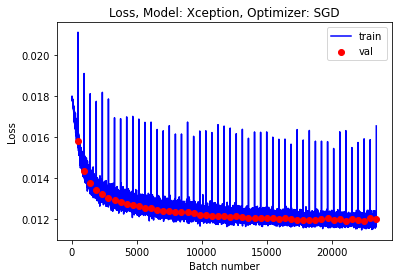

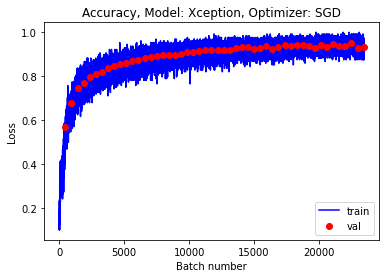

epoch: 50
Xception with SGD training done
Vall loss: 0.011993457818722887 
Vall accuracy: 0.9317863805970149


In [ ]:
train_model(third_model, train_dataloader, test_dataloader, optim.SGD(third_model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-5), 
            'Xception', 'SGD')

In [ ]:
third_model = ThirdModel()
third_model.to('cuda:0')

ThirdModel(
  (layers): ModuleDict(
    (128): Sequential(
      (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (64): Sequential(
      (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(2, 2))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (block): Sequential(
      (0): ReLU()
      (1): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
      (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=128)
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
      (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): Conv2d(128, 128, kernel_size=(3, 3),

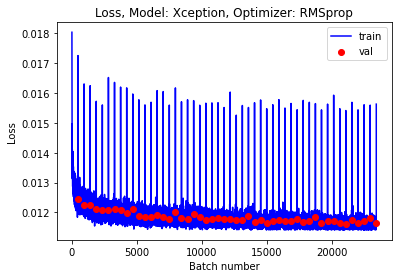

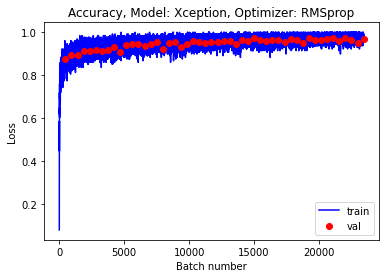

epoch: 50
Xception with RMSprop training done
Vall loss: 0.01166175475493656 
Vall accuracy: 0.9698882818052594


In [ ]:
train_model(third_model, train_dataloader, test_dataloader, optim.RMSprop(third_model.parameters(), lr=0.001, eps=1e-4), 
            'Xception', 'RMSprop')

#### Комментарии

Xception обучился очень плохо на SGD и совсем не обучился на RMSProp. Возможно, dropout помог бы писал я и вспомнил, что еще есть batchnorm, которого тогда в модели не было. Если без batchnorm точность после обучения Xception на SGD составляла около 69%, а на RMSProp обучение не происходило вообще, то после добавления нормализации точность на обоих оптимизаторах значительно выросла и стала сопоставимой с точностью VGG. 

### Общие комментарии

Модель ResNet на 20+ слоев оказалась слишком сложной для FashionMnist при обучении SGD и переобучилась. Лучшие результаты показал VGG с оптимизатором SGD, следующим по успешности был Xception с оптимизатором RMSProp. При этом кажется, что VGG достиг своего максимума, а Xception мог бы улучшить качество при уменьшении learning rate 